In [1]:
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase1\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

TourCompMap = {'All Adult': 'adults', 'All Children': 'children', 'Mixed': 'mixed'}

coef_map = {'adults': 'coef_asc_adults', 'children': 'coef_asc_children', 'mixed': 'coef_asc_mixed'}

tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))
obsJtcomp = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "jointComp.csv")).rename(columns = {'freq': 'ObsN'})
obsJtcomp['composition'] = obsJtcomp['COMPOSITION'].map(TourCompMap)
obsJtcomp['ObsPct'] = obsJtcomp['ObsN'] / obsJtcomp['ObsN'].sum()
obsJtcomp.drop(columns = 'COMPOSITION', inplace = True)
asim_config = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH, "joint_tour_composition_coefficients.csv")).set_index('coefficient_name')

C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_18188\3156708861.py:24: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))


In [2]:
jtc = tours[~tours['composition'].isna()].groupby('composition').agg(model = ('tour_id', 'count'))
jtc['ModPct'] = jtc['model'] / jtc['model'].sum()
compare_data = jtc.join(obsJtcomp.set_index('composition')).reset_index()

plot_data = pd.concat([jtc.reset_index().rename(columns = {'model': 'n', 'ModPct': 'percent'}).assign(source = 'Model'),
    obsJtcomp.rename(columns = {'ObsN': 'n', 'ObsPct': 'percent'}).assign(source = 'Survey')
])

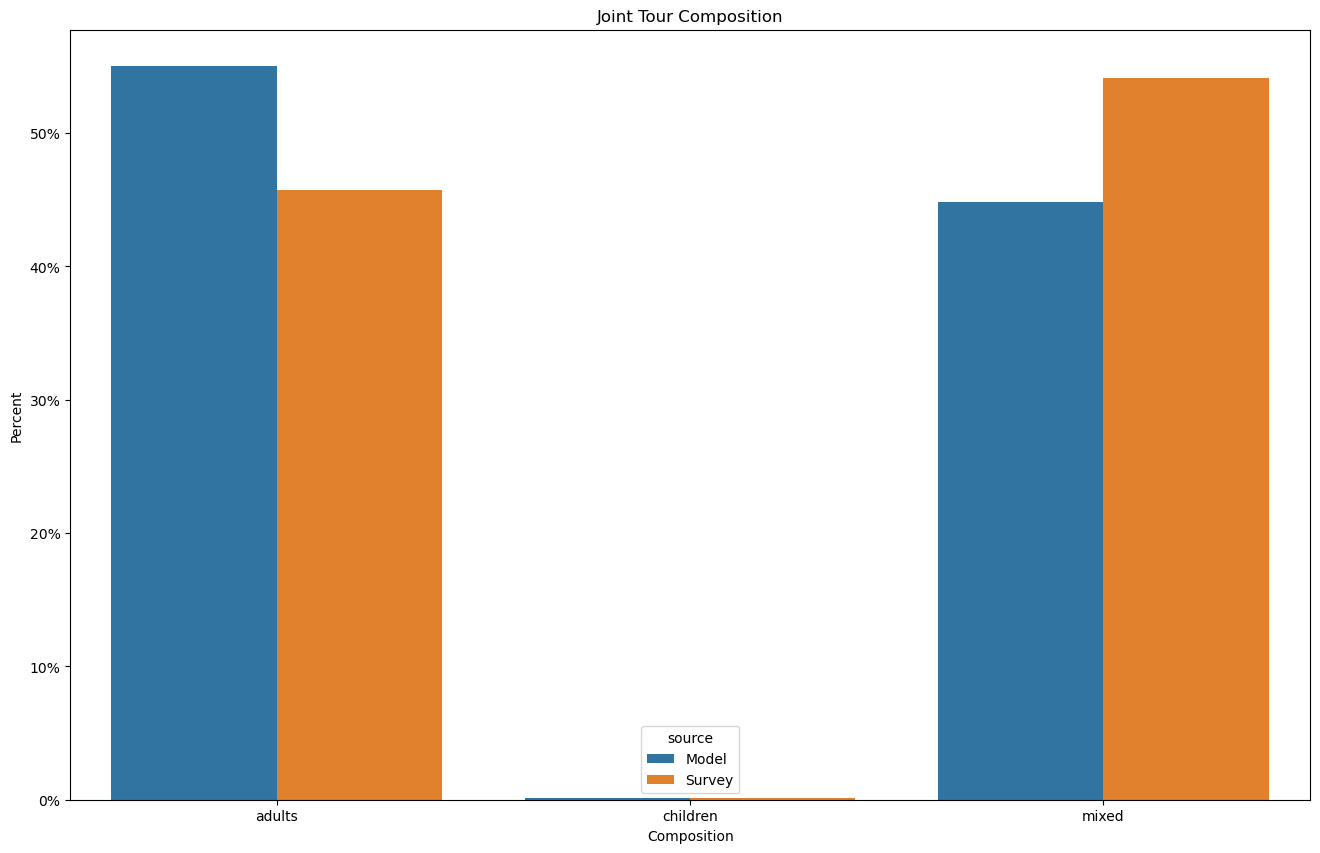

In [3]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
sns.barplot(data = plot_data, x = 'composition', y = 'percent', hue = 'source')
plt.title(f"Joint Tour Composition")
# plt.xticks(fontsize=16, rotation = 90)
# plt.yticks(fontsize=16)
plt.ylabel('Percent')
plt.xlabel('Composition')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))

plt.show()

# Coefficient Update

In [4]:
compare_data['coefficient_name'] = compare_data['composition'].map(coef_map)
compare_data['old_coef'] = np.array(asim_config['value'].reindex(compare_data['coefficient_name']))
compare_data['constrain'] = np.array(asim_config['constrain'].reindex(compare_data['coefficient_name']))
compare_data['adjust'] = np.log(compare_data['ObsPct'] / compare_data['ModPct'])
compare_data['value'] = compare_data['old_coef'] + compare_data['adjust']
compare_data.loc[compare_data['old_coef'].isna(), 'value'] = None
compare_data.loc[compare_data['constrain'] == 'T', 'value'] = compare_data['old_coef']

compare_data

,composition,model,ModPct,ObsN,ObsPct,coefficient_name,old_coef,constrain,adjust,value
0,adults,45777,0.550052,222515.441744,0.457025,coef_asc_adults,-0.187736,F,-0.185275,-0.373011
1,children,106,0.001274,706.274225,0.001451,coef_asc_children,1.399889,F,0.130075,1.529964
2,mixed,37340,0.448674,263656.019495,0.541524,coef_asc_mixed,7.174911,F,0.188091,7.363002


In [5]:
compare_data[~compare_data['constrain'].isna()][['coefficient_name', 'value', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,value,constrain
coef_asc_adults,-0.37301056437282776,F
coef_asc_children,1.5299643866328,F
coef_asc_mixed,7.363002202547819,F
